# ClearGrasp evaluation

In [23]:
import os
import sys
import glob
import numpy as np
from tqdm import tqdm_notebook
import matplotlib.pyplot as plt
import imageio

sys.path.append('/tf/cleargrasp')

In [24]:
sys.path.append('..')
import helper_functions

In [25]:
IMG_HEIGHT = 720
IMG_WIDTH = 1280

In [26]:
def parse_raw_depth_bin(filename, height, width):
    with open(filename, "rb") as f:
        a = f.read()
        mat = np.ndarray(shape=(height, width, 1), dtype='uint16', buffer=a)
        return mat

In [27]:
transparent_depth_files = sorted(glob.glob('../data/dishwasher2/val/transparent/depth/*.bin'))
transparent_rgb_files = sorted(glob.glob('../data/dishwasher2/val/transparent/color/*.png'))
print(f"Transparent depth test size: {len(transparent_depth_files)}")
print(f"Transparent rgb matching size: {len(transparent_rgb_files)}")

transparent_depth = [(parse_raw_depth_bin(transparent_depth_file, IMG_HEIGHT, IMG_WIDTH)).astype(np.float32) / 1000 for transparent_depth_file in transparent_depth_files]
transparent_color = [helper_functions.parse_rgb_img(transparent_rgb_file, IMG_HEIGHT, IMG_WIDTH, mono=False, crop=False) for transparent_rgb_file in transparent_rgb_files]

Transparent depth test size: 26
Transparent rgb matching size: 26


In [28]:
from api import depth_completion_api

depthcomplete = depth_completion_api.DepthToDepthCompletion(normalsWeightsFile='/root/data/cleargrasp/cleargrasp-checkpoints/surface_normals/checkpoint_normals.pth',
                                                            outlinesWeightsFile='/root/data/cleargrasp/cleargrasp-dishwasher-checkpoints/occlusion_boundaries/checkpoint_outlines.pth',
                                                            masksWeightsFile='/root/data/cleargrasp/cleargrasp-dishwasher-checkpoints/mask_segmentation/checkpoint_mask.pth',
                                                            normalsModel='drn',
                                                            outlinesModel='drn',
                                                            masksModel='drn',
                                                            depth2depthExecutable='/tf/cleargrasp/api/depth2depth/gaps/bin/x86_64/depth2depth',
                                                            outputImgHeight=int(IMG_HEIGHT),
                                                            outputImgWidth=int(IMG_WIDTH),
                                                            fx=924,
                                                            fy=924,
                                                            cx=360,
                                                            cy=640,
                                                            filter_d=0,
                                                            filter_sigmaColor=3,
                                                            filter_sigmaSpace=3,
                                                            maskinferenceHeight=256,
                                                            maskinferenceWidth=256,
                                                            normalsInferenceHeight=256,
                                                            normalsInferenceWidth=256,
                                                            outlinesInferenceHeight=256,
                                                            outlinesInferenceWidth=256,
                                                            min_depth=0,
                                                            max_depth=2.0,
                                                            tmp_dir='/root/data/cleargrasp/captures2')

Creating DRN model for normals and loading checkpoint
Creating DRN model for outlines and loading checkpoint
Creating DRN model for masks and loading checkpoint


In [29]:
def save_depth_bin(i, depth):
    depth_clipped = np.clip(depth, 0, 2.0)
    depth_scaled = depth_clipped*1000
    depth_scaled.astype('uint16').tofile(f'../data/dishwasher2/val/cleargrasp_dishwasher_depth/{i:0>2}.bin')

In [30]:
output_depths = []
output_surface_normals_rgb = []
output_mask_predicted = []
output_outlines_rgb = []

for i in tqdm_notebook(range(len(transparent_color))):
    rgb = transparent_color[i]
    depth = transparent_depth[i]
    output_depth, filtered_output_depth = depthcomplete.depth_completion(
                    rgb,
                    depth,
                    inertia_weight=1000.0,
                    smoothness_weight=0.001,
                    tangent_weight=1.0,
                    mode_modify_input_depth='mask')
    output_surface_normals_rgb.append(depthcomplete.surface_normals_rgb)
    output_outlines_rgb.append(depthcomplete.outlines_rgb)
    output_mask_predicted.append(depthcomplete.mask_predicted)
    output_depths.append(output_depth)
    save_depth_bin(i, output_depth)
    imageio.imwrite(f'../data/dishwasher2/val/cleargrasp_dishwasher_mask/{i:0>2}.png', depthcomplete.mask_predicted)
    imageio.imwrite(f'../data/dishwasher2/val/cleargrasp_dishwasher_normals/{i:0>2}.png', depthcomplete.surface_normals_rgb)
    imageio.imwrite(f'../data/dishwasher2/val/cleargrasp_dishwasher_outlines/{i:0>2}.png', depthcomplete.outlines_rgb)
    # depthcomplete.store_depth_completion_outputs('../data/cleargrasp-dishwasher-evaluation', i, min_depth=0, max_depth=2.0)

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:6: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  


  0%|          | 0/26 [00:00<?, ?it/s]

In [31]:
def crop_depth_d2d(mat):
    m, n, _ = mat.shape
    if m > n:
        margin = int((m - n) / 2)
        return mat[margin:margin+n,:]
    elif n > m:
        margin = int((n - m) / 2)
        return mat[:,margin:margin+m,:]
    return mat

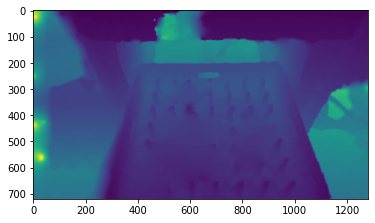

(720, 1280)


FileNotFoundError: [Errno 2] No such file or directory: '../data/dishwasher2/paired/cleargrasp_depth/0.bin'

In [32]:
for i in range(len(output_depths)):
    depth = output_depths[i]
    #depth_cropped = crop_depth_d2d(tf.expand_dims(depth, 2))
    #depth_resized = resize_depth(depth_cropped)
    depth_clipped = np.clip(depth, 0, 2.0)
    depth_scaled = depth_clipped*1000
    plt.imshow(depth_scaled)
    plt.show()
    #os.remove(f'data/dishwasher2/paired/cleargrasp_depth/{i}.npy')
    print(depth_scaled.shape)
    depth_scaled.astype('uint16').tofile(f'../data/dishwasher2/paired/cleargrasp_depth/{i}.bin')

In [143]:
os.getcwd()

'/root/evaluation'